In [1]:
!pip install tensorflow

In [2]:
from google.colab import files
import pandas as pd

uploaded = files.upload()



Saving True.csv to True.csv


In [4]:
from google.colab import files
import pandas as pd

uploaded = files.upload()



Saving Fake (2).csv to Fake (2).csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [7]:
import pandas as pd


true_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake (2).csv')

true_df['label'] = 1
fake_df['label'] = 0

# Combine them
data = pd.concat([true_df, fake_df], ignore_index=True)


/tmp/ipython-input-7-3524062720.py:5: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  fake_df = pd.read_csv('Fake (2).csv')


In [8]:
data = data.sample(frac=1).reset_index(drop=True)


In [9]:
# Drop rows with missing text
data.dropna(subset=['text'], inplace=True)

# Optional: clean text
import re
import re

def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove unwanted characters but keep $, %, ., commas, and digits
    text = re.sub(r'[^\w\s$%.,]', '', text)

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)

    # Lowercase
    return text.lower().strip()

data['text'] = data['text'].apply(clean_text)

In [10]:
from sklearn.utils import resample

real_df = data[data['label'] == 1]
fake_df = data[data['label'] == 0]

# Upsample real news
real_upsampled = resample(real_df,
                          replace=True,         # sample with replacement
                          n_samples=len(fake_df),  # match fake news count
                          random_state=42)

balanced_data = pd.concat([real_upsampled, fake_df])
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)  # shuffle


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(data['text'])
y = data['label']


In [12]:
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
import pickle # Import pickle
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])

# Save Label Encoder
with open("label_encoder.pkl", "wb") as f:

    pickle.dump(label_encoder, f)


In [13]:
# STEP 3: Label Encoding
# -----------------------------------------------------
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
label_encoder = LabelEncoder()
data["label_encoded"] = label_encoder.fit_transform(data["label"])

# Save Label Encoder
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [14]:
# STEP 4: Train/Test Split
# -----------------------------------------------------
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1, 3))
X_train = tfidf.fit_transform(train_df["text"])
X_test = tfidf.transform(test_df["text"])
y_train = train_df["label_encoded"]
y_test = test_df["label_encoded"]

# Save TF-IDF
with open("vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

In [15]:
# One-hot encoding for Neural Net
y_train_oh = to_categorical(y_train)
y_test_oh = to_categorical(y_test)


/tmp/ipython-input-16-4153740990.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')


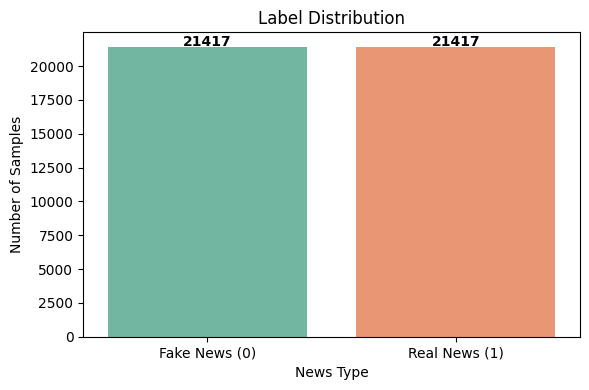

In [16]:

# Count the number of real (1) and fake (0) labels
label_counts = data['label'].value_counts()


# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='Set2')

# Customize the plot
plt.xticks([0, 1], ['Fake News (0)', 'Real News (1)'])
plt.title('Label Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('News Type')

# Show counts on top of bars
for index, value in enumerate(label_counts.values):
    plt.text(index, value + 50, str(value), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


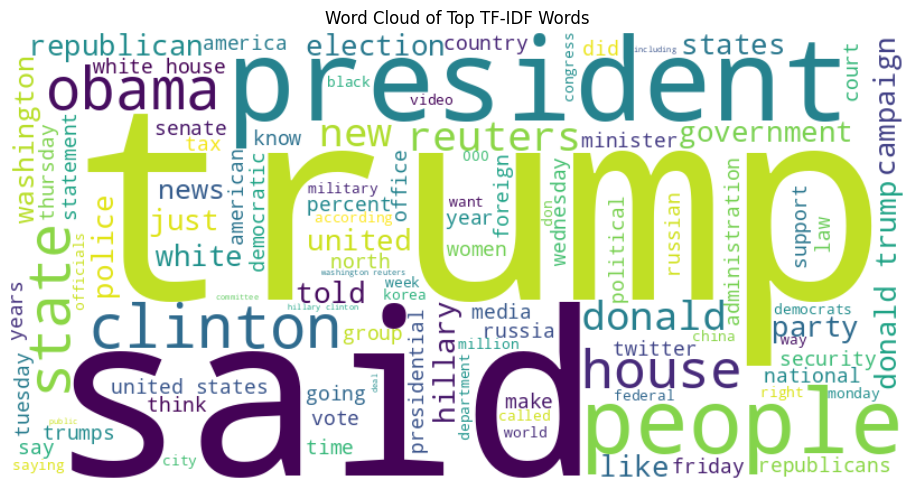

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ────────────────────────────────────────────────
# Extract feature names (words)
feature_names = tfidf.get_feature_names_out()

# Sum TF-IDF scores across all documents to get importance
word_tfidf_sums = X_train.sum(axis=0).A1  # Converts sparse matrix to flat array

# Create dictionary of word: total tf-idf score
tfidf_scores = dict(zip(feature_names, word_tfidf_sums))

# Sort by highest scores
sorted_tfidf = dict(sorted(tfidf_scores.items(), key=lambda item: item[1], reverse=True))

# Take top N words
top_n = 100
top_words = dict(list(sorted_tfidf.items())[:top_n])

# ────────────────────────────────────────────────

# ────────────────────────────────────────────────
# 2. Word Cloud of TF-IDF Words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Top TF-IDF Words")
plt.tight_layout()
plt.show()


/tmp/ipython-input-18-3650682634.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="viridis")


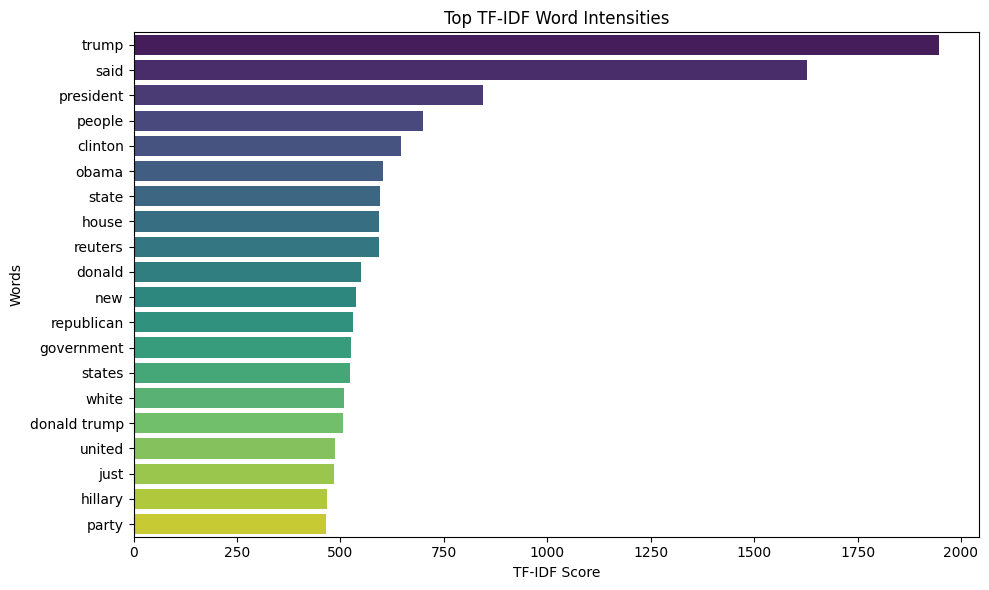

In [18]:
# 1. Bar Plot for Top TF-IDF Words
top_n = 20
top_words = dict(list(sorted_tfidf.items())[:top_n])

plt.figure(figsize=(10, 6))
sns.barplot(x=list(top_words.values()), y=list(top_words.keys()), palette="viridis")
plt.title("Top TF-IDF Word Intensities")
plt.xlabel("TF-IDF Score")
plt.ylabel("Words")
plt.tight_layout()
plt.show()


In [19]:
# -----------------------------------------------------
# Logistic Regression
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
lr_pred = model.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, lr_pred))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4291
           1       0.99      0.99      0.99      4276

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       0.99      0.99      0.99      8567



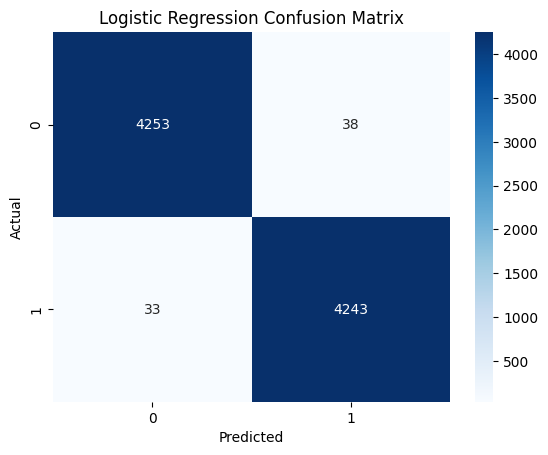

🔍 Examples of real news misclassified as fake:

🔍 Examples of real news misclassified as fake:
- reuters a federal judge in texas on saturday issued a court order barring enforcement of an obama administration policy seeking to extend antidiscrimination protections under the affordable care act t...
- barcelona reuters brazilian felipe massa completed two and a half race distances and put his williams team on top of the timesheets as formula ones final preseason test got underway in barcelona on tu...
- washington reuters clarence thomas ended a decade of silence from the bench during supreme court arguments on monday when the conservative justice unexpectedly posed questions during a gun rights case...


In [20]:
# ----- Show confusion matrix -----
import seaborn as sns
import matplotlib.pyplot as plt

# Use lr_pred instead of the undefined y_pred
sns.heatmap(confusion_matrix(y_test, lr_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression Confusion Matrix')
plt.show()


print("🔍 Examples of real news misclassified as fake:")

misclassified_indices = test_df.index[(y_test == 1).values & (lr_pred == 0)]

if len(misclassified_indices) > 0:
    print("\n🔍 Examples of real news misclassified as fake:")
    # Sample up to 3 indices and print the original text
    for idx in np.random.choice(misclassified_indices, min(3, len(misclassified_indices)), replace=False):
        # Find the row in the original data or test_df using the index
        original_row = test_df.loc[idx]
        print(f"- {original_row['text'][:200]}...") # Print first 200 chars
else:
    print("\n✅ No real news misclassified as fake found.")

In [21]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)
print("Naive Bayes:")
print(classification_report(y_test, nb_pred))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4291
           1       0.93      0.95      0.94      4276

    accuracy                           0.94      8567
   macro avg       0.94      0.94      0.94      8567
weighted avg       0.94      0.94      0.94      8567



In [22]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, rf_pred))

Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4291
           1       1.00      1.00      1.00      4276

    accuracy                           1.00      8567
   macro avg       1.00      1.00      1.00      8567
weighted avg       1.00      1.00      1.00      8567



In [23]:
from sklearn.utils import class_weight

# Compute weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

# Define the model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(label_encoder.classes_), activation='softmax')
])
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train with class weights
nn_model.fit(X_train.toarray(), y_train_oh,
             epochs=30,
             batch_size=16,
             validation_split=0.2,
             callbacks=[early_stop],
             class_weight=class_weights)

# Predict
nn_pred = np.argmax(nn_model.predict(X_test.toarray()), axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.9436 - loss: 0.1395 - val_accuracy: 0.9915 - val_loss: 0.0262
Epoch 2/30
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.9967 - loss: 0.0102 - val_accuracy: 0.9946 - val_loss: 0.0264
Epoch 3/30
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9991 - loss: 0.0028 - val_accuracy: 0.9937 - val_loss: 0.0296
Epoch 4/30
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9991 - loss: 0.0026 - val_accuracy: 0.9931 - val_loss: 0.0284
268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step



📊 Evaluation for Logistic Regression
Accuracy: 0.9917123847321115
Precision: 0.9917130716377026
Recall: 0.9917123847321115
F1 Score: 0.9917123903781345
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4291
           1       0.99      0.99      0.99      4276

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       0.99      0.99      0.99      8567



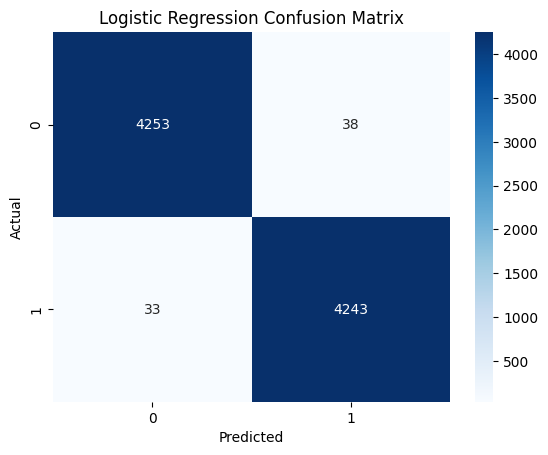


📊 Evaluation for Naive Bayes
Accuracy: 0.9389517917590755
Precision: 0.9393534399291924
Recall: 0.9389517917590755
F1 Score: 0.9389395572412399
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      4291
           1       0.93      0.95      0.94      4276

    accuracy                           0.94      8567
   macro avg       0.94      0.94      0.94      8567
weighted avg       0.94      0.94      0.94      8567



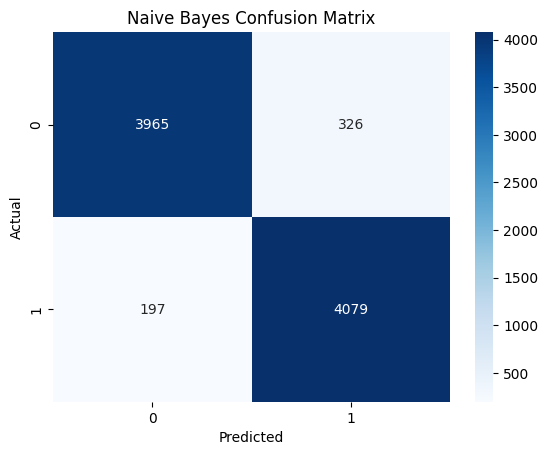


📊 Evaluation for Random Forest
Accuracy: 0.9978989144391269
Precision: 0.997899352048548
Recall: 0.9978989144391269
F1 Score: 0.997898915698747
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4291
           1       1.00      1.00      1.00      4276

    accuracy                           1.00      8567
   macro avg       1.00      1.00      1.00      8567
weighted avg       1.00      1.00      1.00      8567



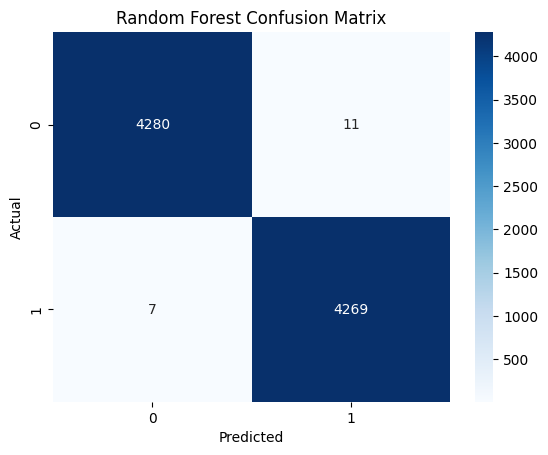


📊 Evaluation for Neural Network
Accuracy: 0.9914789307809034
Precision: 0.9915116249052172
Recall: 0.9914789307809034
F1 Score: 0.9914787275969521
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      4291
           1       1.00      0.99      0.99      4276

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       0.99      0.99      0.99      8567



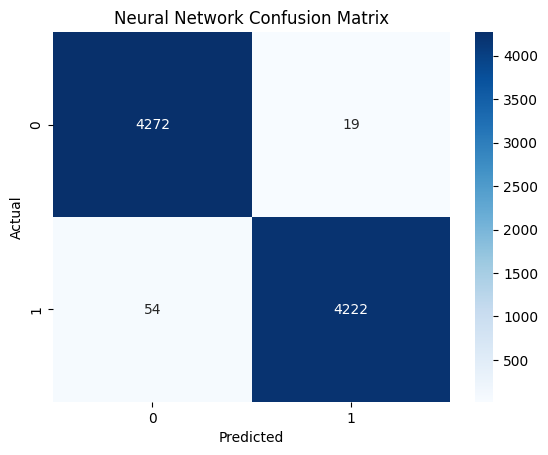

In [24]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 Evaluation for {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, average='weighted'))
    print("Recall:", recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['0', '1']))

    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Logistic Regression", y_test, lr_pred)
evaluate_model("Naive Bayes", y_test, nb_pred)
evaluate_model("Random Forest", y_test, rf_pred)
evaluate_model("Neural Network", y_test, nn_pred)


In [25]:
# STEP 7: Save Best Model
# -----------------------------------------------------
with open("best_fake_news_model.pkl", "wb") as f:
    pickle.dump(model, f)

print("\n✅ Best model and vectorizer saved.")


✅ Best model and vectorizer saved.


In [26]:
def predict_fake_news(text):
    import pickle


    # Load model
    with open("best_fake_news_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Load TF-IDF vectorizer
    with open("vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    # Load Label Encoder
    with open("label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)

    # Transform input text
    vector = vectorizer.transform([text])

    # Predict (numeric label)
    prediction = model.predict(vector)[0]

    # Convert numeric label back to string label (e.g., 'fake' or 'real')
    result = label_encoder.inverse_transform([prediction])[0]

    return result


In [ ]:
sample = "NASA has announced the discovery of water on Mars in the upcoming mission."
print("\n🧪 Sample prediction:")
print(predict_fake_news(sample))


🧪 Sample prediction:
0


In [27]:
# chatbot_app.py
import streamlit as st
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Load the trained model and TF-IDF vectorizer
with open("best_fake_news_model.pkl", "rb") as f:
    model = pickle.load(f)

with open("vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)

# Recreate label encoder with known classes
label_encoder = LabelEncoder()
import numpy as np
label_encoder.classes_ = np.array(['fake', 'real'])
# Prediction function
def predict_fake_news(text):
    import pickle

    # Load model
    with open("best_fake_news_model.pkl", "rb") as f:
        model = pickle.load(f)

    # Load TF-IDF vectorizer
    with open("vectorizer.pkl", "rb") as f:
        vectorizer = pickle.load(f)

    # Load Label Encoder
    with open("label_encoder.pkl", "rb") as f:
        label_encoder = pickle.load(f)

    # Transform input text
    vector = vectorizer.transform([text])

    # Predict (numeric label)
    prediction = model.predict(vector)[0]

    # Convert numeric label back to string label (e.g., 'fake' or 'real')
    result = label_encoder.inverse_transform([prediction])[0]

    return result
# Streamlit App UI
st.set_page_config(page_title="Fake News Detection", page_icon="📰")
st.title("📰 Fake News Detection Chatbot")
st.markdown("Check if a news statement is **real or fake** using a trained ML model.")

user_input = st.text_area("✍️ Enter a news statement below:")

if st.button("🔍 Predict"):
    if user_input.strip():
        result = predict_fake_news(user_input)
        st.success(f"🧠 The statement is predicted to be: **{result}**")
    else:
        st.warning("⚠️ Please enter a statement to check.")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
!pwd

/content


In [ ]:
!ls

 best_fake_news_model.pkl   Fake.csv    label_encoder.pkl   True.csv
'chatbot_app (1).py'	    Fake.xlsx   sample_data	    vectorizer.pkl


In [ ]:
!curl ifconfig.me

34.34.6.110

In [ ]:
!npm install -g localtunnel
!streamlit run chatbot_app.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋
changed 22 packages in 1s
⠋
⠋3 packages are looking for funding
⠋  run `npm fund` for details
⠋⠙⠹⠸

⠼⠴⠦⠧
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.34.6.110:8501

⠇⠏⠋⠙⠹your url is: https://rare-crabs-yawn.loca.lt


In [ ]:
!pip install -q streamlit pyngrok



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
# launch_chatbot.py
from pyngrok import ngrok
import os
import time

# 1️⃣ Set your actual ngrok auth token
ngrok.set_auth_token("2yJ8ZGqsOgdQLhm0yVLZnWgynKh_EHwsZfUcthU8DCMP7CNF")  # Replace this

# 2️⃣ Kill previous tunnels
ngrok.kill()


# 3️⃣ Launch Streamlit app
os.system("streamlit run chatbot_app.py (1) &")
time.sleep(5)

# 4️⃣ Open tunnel on port 8501
public_url = ngrok.connect(8501)

# 5️⃣ Print link
print("🌍 Chatbot is live! Visit:")
print(public_url)


ERROR:pyngrok.process.ngrok:t=2025-06-28T12:23:48+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-06-28T12:23:48+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

PyngrokNgrokError: The ngrok process errored on start: authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n.